In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA'

In [1]:
!du -sh /home/roman/mne_data


60G	/home/roman/mne_data


In [2]:
import sys, os, torch
from tqdm import tqdm
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
%%time

ds = Zhou2016()
print(f'Interval: {ds.interval}')

print(f'N_subj: {len(ds.subject_list)}')


# ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
ChOI = ['FC3',
     'FC4',
     'FCz',
     'Cz',
     'CP3',
     'CP4',
     'CPz']
eventsOI  = ['left_hand', 'right_hand']

subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=0,
                            tmax=None, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)
    print(ch_names)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)



Interval: [0, 5]
N_subj: 4


  0%|                                                                                                                                   | 0/4 [00:00<?, ?it/s]

['left_hand', 'right_hand', 'feet']
Reading 0 ... 305029  =      0.000 ...  1220.116 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 430479  =      0.000 ...  1721.916 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 252599  =      0.000 ...  1010.396 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 296649  =      0.000 ...  1186.596 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/cnt/cnt.py:239: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 233249  =      0.000 ...   932.996 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 226219  =      0.000 ...   904.876 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


['VEOU', 'VEOL', 'Fp1', 'Fp2', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'O1', 'Oz', 'O2']
Reading 0 ... 305029  =      0.000 ...  1220.116 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 430479  =      0.000 ...  1721.916 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 252599  =      0.000 ...  1010.396 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 296649  =      0.000 ...  1186.596 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 233249  =      0.000 ...   932.996 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 226219  =      0.000 ...   904.876 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
 25%|██████████████████████████████▊                                                                                            | 1/4 [00:04<00:13,  4.44s/it]

(319, 7, 300), ['feet' 'left_hand' 'right_hand']
['left_hand', 'right_hand', 'feet']
Reading 0 ... 227539  =      0.000 ...   910.156 secs...
Reading 0 ... 216079  =      0.000 ...   864.316 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/cnt/cnt.py:239: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 213939  =      0.000 ...   855.756 secs...
Reading 0 ... 175269  =      0.000 ...   701.076 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 213209  =      0.000 ...   852.836 secs...
Reading 0 ... 217659  =      0.000 ...   870.636 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


['VEOU', 'VEOL', 'Fp1', 'Fp2', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'O1', 'Oz', 'O2']
Reading 0 ... 227539  =      0.000 ...   910.156 secs...
Reading 0 ... 216079  =      0.000 ...   864.316 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 213939  =      0.000 ...   855.756 secs...
Reading 0 ... 175269  =      0.000 ...   701.076 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 213209  =      0.000 ...   852.836 secs...
Reading 0 ... 217659  =      0.000 ...   870.636 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
 50%|█████████████████████

(290, 7, 300), ['feet' 'left_hand' 'right_hand']
['left_hand', 'right_hand', 'feet']
Reading 0 ... 219849  =      0.000 ...   879.396 secs...
Reading 0 ... 216709  =      0.000 ...   866.836 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 226609  =      0.000 ...   906.436 secs...
Reading 0 ... 266929  =      0.000 ...  1067.716 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 227989  =      0.000 ...   911.956 secs...
Reading 0 ... 222459  =      0.000 ...   889.836 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/cnt/cnt.py:239: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


['VEOU', 'VEOL', 'Fp1', 'Fp2', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'O1', 'Oz', 'O2']
Reading 0 ... 219849  =      0.000 ...   879.396 secs...
Reading 0 ... 216709  =      0.000 ...   866.836 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 226609  =      0.000 ...   906.436 secs...
Reading 0 ... 266929  =      0.000 ...  1067.716 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 227989  =      0.000 ...   911.956 secs...
Reading 0 ... 222459  =      0.000 ...   889.836 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3/4 [00:10<00:03,  3.51s/it]

(300, 7, 300), ['feet' 'left_hand' 'right_hand']
['left_hand', 'right_hand', 'feet']
Reading 0 ... 181339  =      0.000 ...   725.356 secs...
Reading 0 ... 217139  =      0.000 ...   868.556 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 215399  =      0.000 ...   861.596 secs...
Reading 0 ... 212209  =      0.000 ...   848.836 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 209799  =      0.000 ...   839.196 secs...
Reading 0 ... 217109  =      0.000 ...   868.436 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


['VEOU', 'VEOL', 'Fp1', 'Fp2', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'O1', 'Oz', 'O2']
Reading 0 ... 181339  =      0.000 ...   725.356 secs...
Reading 0 ... 217139  =      0.000 ...   868.556 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 215399  =      0.000 ...   861.596 secs...
Reading 0 ... 212209  =      0.000 ...   848.836 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


Reading 0 ... 209799  =      0.000 ...   839.196 secs...
Reading 0 ... 217109  =      0.000 ...   868.436 secs...


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/moabb/datasets/Zhou2016.py:102: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.49s/it]

(290, 7, 300), ['feet' 'left_hand' 'right_hand']
CPU times: user 13.3 s, sys: 661 ms, total: 13.9 s
Wall time: 14 s


In [5]:
labelsToIDs = {"right_hand": 0, "left_hand": 1}

def save_to_torch(samples, meta, ds):    
    torch.save({'samples': torch.from_numpy(samples).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ChOI,
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

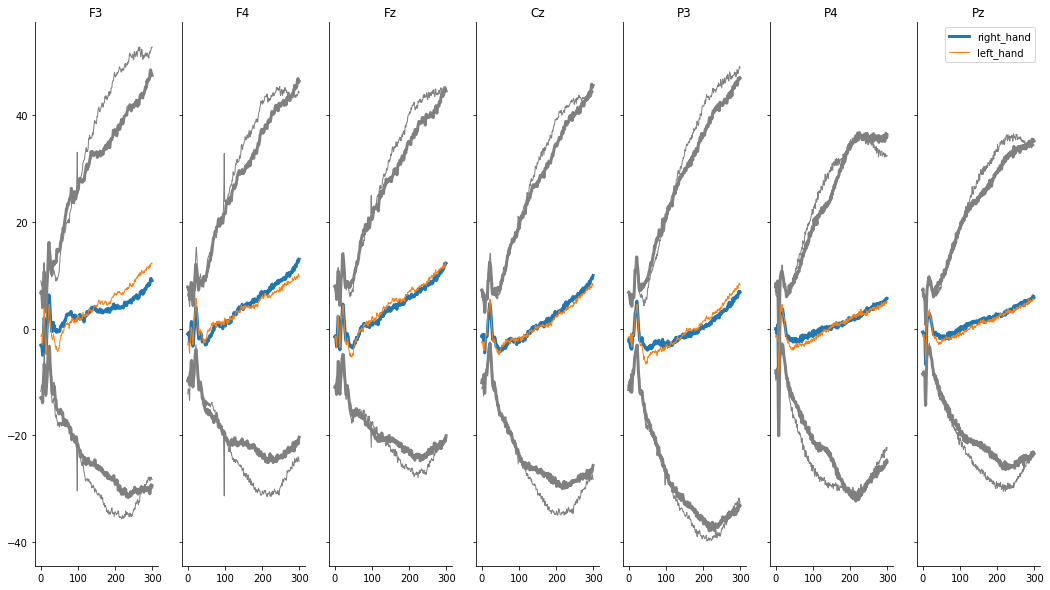

In [6]:
rights = np.where(meta.label.map(labelsToIDs) == 0)[0]
lefts = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1,7, figsize=(18,10), sharey=True)
for i in range(7):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[lefts,i,:].mean(0).squeeze()
    s = samples[lefts,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='left_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()